In [0]:
!ls

test  train  valid


In [0]:
### Let's start by importing what we gonna need
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
from torch.utils.data import DataLoader as dload
import torchvision as tv
import torchvision.models as mod
import torchvision.transforms as trn
import torchvision.datasets as dsets
from torchsummary import summary as summ
from torch.utils.tensorboard import SummaryWriter as sw

import scipy.io as sio
import matplotlib.pyplot as plt
from PIL import Image as im
import time
import os
import numpy as np

In [0]:
### now download the dataset

!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/extra_32x32.mat
  
tr = sio.loadmat("train_32x32.mat")
ts = sio.loadmat("test_32x32.mat")
xt = sio.loadmat("extra_32x32.mat")

!rm -r *.mat sample_data  ### to save some room cuz all this shit is more than 1GB


--2019-09-10 15:35:46--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  16.6MB/s    in 14s     

2019-09-10 15:36:01 (12.4 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2019-09-10 15:36:02--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  15.8MB/s    in 7.5s    

2019-09-10 15:36:10 (8.19 MB/s) - ‘test_32x32.mat’ saved [64275384/64

In [0]:
def see(m, k):
  """ This tiny function shall be useful to visualize some samples within our datasets,
      it will show the kth sample in the m matrix """
  print(m['y'][k])
  plt.imshow(m['X'][:,:,:,k]) ; plt.show()
  

[1]


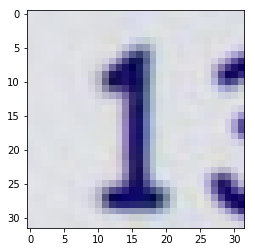

In [0]:
####### Let's try it
####### Reminder : the train set is stored as tr, test set as ts and extra set as xt
see(ts, 4178)

In [0]:
###### Now it's time to create our train, test and validation directories,


!mkdir train test valid
!for i in `seq 01 10` ; do mkdir train/$i test/$i valid/$i ; done

In [0]:
##### and fill them, let's write a function for that

def fill(m, d, n, x):
  """ m is the matrix, d the directory (string) we gonna fill, n (int) is how much we gonna put into the dir,
      I added it beacause of the extra set, finally x (string) is to create a file name to avoid conflicts, once again because of xtra"""
  q = m['X'].shape[3] - n
  for k in range(q):
    path = d + "/" + str(m['y'][k, 0]) 
    if len(os.listdir(path)) < 50000:        ### This is to have a balenced number of samples in each dir
      path = path + "/" + x + str(k) + ".png"
      plt.imsave(path, m['X'][:, :, :, k])
    

In [0]:
fill(tr, "train", 0, "tr")
fill(ts, "test", 0, "ts")

##### the extra set : we gonna use most of it for the train set

fill(xt, "train", 50000, "xt")

##### and the rest will go to validation, we'll do it without the function

s_idx = xt['X'].shape[3] - 50000

for k in range(s_idx, xt['X'].shape[3]):
  
  path = "valid/" + str(xt['y'][k, 0]) + "/xt" + str(k) + ".png"
  plt.imsave(path, xt['X'][:, :, :, k])


In [0]:
### you can run that shell command to check how many samples are stored in each subdirectory
!for dir in `ls` ; do for i in `seq 01 10` ; do x=`ls -l $dir/$i | wc -l`; echo "$x samples in $dir/$i"; done; printf "\n" ; done

5100 samples in test/1
4150 samples in test/2
2883 samples in test/3
2524 samples in test/4
2385 samples in test/5
1978 samples in test/6
2020 samples in test/7
1661 samples in test/8
1596 samples in test/9
1745 samples in test/10

50001 samples in train/1
50001 samples in train/2
50001 samples in train/3
50001 samples in train/4
50001 samples in train/5
43385 samples in train/6
45523 samples in train/7
37016 samples in train/8
35816 samples in train/9
46270 samples in train/10

8439 samples in valid/1
7166 samples in valid/2
5758 samples in valid/3
4807 samples in valid/4
4923 samples in valid/5
3926 samples in valid/6
4071 samples in valid/7
3389 samples in valid/8
3301 samples in valid/9
4230 samples in valid/10



In [0]:
"""
Transfert learning that didn't work because of preprocessing that made images 7 times bigger


###### All right that was the easy part, let's get into the interesting one
###### This is an image classification problem and I gonna use transfert learning to solve it
###### So first of all we will need a state of the art pretrained model and torchvision shallt be very useful for that


md = mod.resnet18(pretrained=True)   ### I took that one cuz it got good accuracy performances
                                      ### I initilially wanted to use inception-v3 but it's a pain in the ass

####### Let's bring a few changes to it for our transfert learning

# first, put its parameters into the freezer
for param in md.parameters():
    param.requires_grad = False

# now we gotta change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = md.fc.in_features

## and add this salad
md.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    #nn.Dropout(0.4),
    nn.Linear(256, 10), 
    nn.Softmax(dim=1) 
)

## define a batch size
bs = 128

# finally we need an optimizer and a loss function
loss_func = nn.CrossEntropyLoss()
optimizer = opt.RMSprop(md.parameters(), lr = 0.0001)

#Let's see how it looks like
md.cuda()
summ(md, input_size=(3, 224, 224), batch_size=bs, device='cuda') #### Inception works with 299*299 pics"""

In [0]:
###### Let's make our nn receipe, first the ingredients :


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 25, 5)   ### output = 25*28*28
        self.pool = nn.MaxPool2d(2, 2)     ### output = 25*14*14
        self.conv2 = nn.Conv2d(25, 40, 5)  ### output = 40*10*10
        self.fc1 = nn.Linear(40 * 5 * 5, 256)  ####  there is a 2nd 2x2 max pooling, check the forward method below
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)
        self.smax = nn.Softmax(dim=1) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 40 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.smax(x)
        return x
      

      
md = Net()
# season it with an optimizer and a loss function
loss_func = nn.CrossEntropyLoss()
optimizer = opt.RMSprop(md.parameters(), lr = 0.0001)
bs = 128

#Let's see how it looks like
md.cuda()
summ(md, input_size=(3, 32, 32), batch_size=bs, device='cuda')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [128, 25, 28, 28]           1,900
         MaxPool2d-2          [128, 25, 14, 14]               0
            Conv2d-3          [128, 40, 10, 10]          25,040
         MaxPool2d-4            [128, 40, 5, 5]               0
            Linear-5                 [128, 256]         256,256
            Linear-6                  [128, 64]          16,448
            Linear-7                  [128, 10]             650
           Softmax-8                  [128, 10]               0
Total params: 300,294
Trainable params: 300,294
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 1.50
Forward/backward pass size (MB): 29.14
Params size (MB): 1.15
Estimated Total Size (MB): 31.79
----------------------------------------------------------------


In [0]:
####### Now that we defined our model, let's take care of the data.

### We'll need to preprocess the images before feeding inception with them, once again torchvision is helpful for that

### let's define our transorms :


image_tr = { 
    'train': trn.Compose([
        #trn.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        trn.RandomRotation(degrees=15),   #### We only use that for data augmentation 
        #trn.CenterCrop(size=224),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406],
                     [0.229, 0.224, 0.225])   
    ]),
    'v&t': trn.Compose([  ### validation and test, same preprocess seasoning for them 
       # trn.Resize(size=256),
        #trn.CenterCrop(size=224),
        trn.ToTensor(),
        trn.Normalize([0.485, 0.456, 0.406],
                     [0.229, 0.224, 0.225])
    ])
   
}


###### Now it's time to oil up the data for training (get it ready if you prefer)

### First let's load it, train and validation sets only
data = {
    'train': dsets.ImageFolder(root="train", transform=image_tr['train']),
    'valid': dsets.ImageFolder(root="valid", transform=image_tr['v&t'])    
}

train_data_loader = dload(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = dload(data['valid'], batch_size=bs, shuffle=True)

# let's get a mapping of the indices to the class names,even if it's 1 2 3 etc
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}


# we'll also need their size to compute the loss and accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])

In [0]:
###### Now we need a couple of custom functions: we need one for training and validating and one for predictions

def train_and_validate(model, loss_criterion, optimizer, train_data_loader, 
                       valid_data_loader, train_data_size, valid_data_size, epochs=25):
    '''
    Function to train and validate
     
    Returns:
        model: Trained Model with best validation accuracy
        history: everything we need to draw curves
        
    I'd like to add callbacks but it's not provided in PyTorch, which is its only weakness (the only one I know so far)
    '''
    
    ### First of all let's preheat our CUDA oven
    
    device = t.device("cuda")
    
    ### and a timer
    start = time.time()
    
    #### and initialize what we gonna return 
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = t.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = t.mean(correct_counts.type(t.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            ### uncoment the following line at your own risk
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}\n".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with t.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = t.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = t.mean(correct_counts.type(t.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                
                ### uncoment the following line at your own risk
                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}\n".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n Validation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s\n\n".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
            
    return model, history

In [0]:
def predict(test_image_name):
    '''
    Function to predict the class of a single test image


    '''

    test_image = im.open(test_image_name).convert('RGB')
    plt.imshow(test_image)
    
    test_image_tensor = image_tr['v&t'](test_image)
    
    test_image_tensor = test_image_tensor.view(1, 3, 32, 32).cuda() ### Don't forget to put it into the oven
    
    with t.no_grad():
        md.eval()
        # Model outputs log probabilities
        out = md(test_image_tensor)        
        topk, topclass = out.topk(3, dim=1)
        for i in range(3):
            print("Predcition", i+1, ":", idx_to_class[topclass.cpu().numpy()[0][i]], ", Score: ", topk.cpu().numpy()[0][i])

In [0]:
##### Our functions are ready, we can start practicing now

trained_model, history = train_and_validate(md, loss_func, optimizer, train_data_loader, valid_data_loader, train_data_size, valid_data_size, 30)
 										
####torch.save(history, 'myhistory.pt')



Epoch: 1/30
Epoch : 000, Training: Loss: 1.5840, Accuracy: 87.7619%, 
 Validation : Loss : 1.5578, Accuracy: 90.3600%, Time: 189.2623s


Epoch: 2/30
Epoch : 001, Training: Loss: 1.5820, Accuracy: 87.9235%, 
 Validation : Loss : 1.5558, Accuracy: 90.5100%, Time: 187.2706s


Epoch: 3/30
Epoch : 002, Training: Loss: 1.5799, Accuracy: 88.1359%, 
 Validation : Loss : 1.5540, Accuracy: 90.6740%, Time: 186.5880s


Epoch: 4/30
Epoch : 003, Training: Loss: 1.5788, Accuracy: 88.2305%, 
 Validation : Loss : 1.5547, Accuracy: 90.6240%, Time: 186.7671s


Epoch: 5/30
Epoch : 004, Training: Loss: 1.5773, Accuracy: 88.3665%, 
 Validation : Loss : 1.5537, Accuracy: 90.7140%, Time: 187.0140s


Epoch: 6/30
Epoch : 005, Training: Loss: 1.5699, Accuracy: 89.1436%, 
 Validation : Loss : 1.4986, Accuracy: 96.4000%, Time: 186.5683s


Epoch: 7/30
Epoch : 006, Training: Loss: 1.5095, Accuracy: 95.3175%, 
 Validation : Loss : 1.4943, Accuracy: 96.7940%, Time: 186.7606s


Epoch: 8/30
Epoch : 007, Training: Loss: 

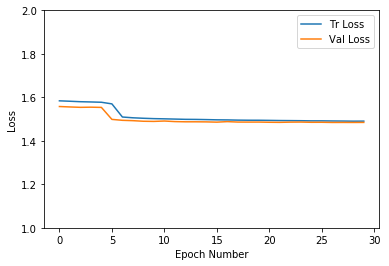

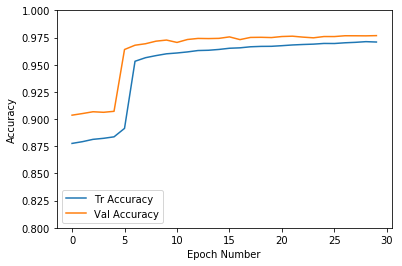

In [0]:
################# draw the training curves
history = np.array(history)    


######## loss curves
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(1,2)
plt.show()

####### accuracy curves
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0.8,1)
plt.show()

Predcition 1 : 10 , Score:  0.9999964
Predcition 2 : 6 , Score:  3.536872e-06
Predcition 3 : 8 , Score:  4.076106e-11


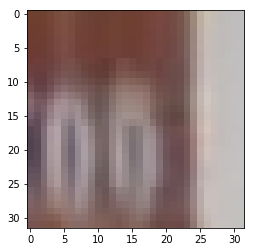

In [0]:
#### Now let's try some predictions, use the cell below to see the file names

sample = "test/10/ts2164.png"
predict(sample)

In [0]:
!ls test/10

ts10021.png  ts13916.png  ts17604.png  ts21628.png  ts25859.png  ts6232.png
ts10027.png  ts13924.png  ts17619.png  ts21635.png  ts25868.png  ts6240.png
ts10033.png  ts1393.png   ts17636.png  ts2163.png   ts25880.png  ts6261.png
ts10035.png  ts13948.png  ts17653.png  ts21643.png  ts25882.png  ts6274.png
ts10051.png  ts13975.png  ts17673.png  ts2164.png   ts25898.png  ts6296.png
ts10052.png  ts13981.png  ts17687.png  ts21659.png  ts2590.png	 ts6312.png
ts10054.png  ts13990.png  ts17718.png  ts21712.png  ts25917.png  ts6349.png
ts10056.png  ts14003.png  ts1773.png   ts21721.png  ts25939.png  ts6364.png
ts10060.png  ts14005.png  ts17776.png  ts21723.png  ts2593.png	 ts6366.png
ts10067.png  ts14009.png  ts17789.png  ts21730.png  ts25941.png  ts6369.png
ts10099.png  ts1400.png   ts17791.png  ts21768.png  ts25945.png  ts6388.png
ts10107.png  ts14021.png  ts17799.png  ts2176.png   ts25949.png  ts6396.png
ts10112.png  ts14023.png  ts17826.png  ts21794.png  ts25966.png  ts6425.png
ts1012.png   t